In [3]:
import numpy as np
import numpy.random as nr
import random
#import itertools
import scipy.misc

import matplotlib
import matplotlib.pyplot as plt

#%matplotlib notebook
#%matplotlib qt 
%matplotlib inline 
import time
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})


from grid_world_new import grid_world

In [4]:
# adjust this to handle grid world stuff // should it just be adjusted in general or a new one?
class Qagent():
    def __init__(self,params,n_states, n_actions = [], Tsas = [], Rsa = [], grid = False):

        self.params = params
        self.n_states = n_states
        
        if grid:
            n_actions = np.tile(4,n_states).astype(int)
        
        self.n_actions = n_actions # n actions in each state, a list
        
        self.n_state_actions = np.sum(n_actions)
        n_actions_max = np.max(n_actions)
        n_state_actions = np.sum(n_actions)
        
        self.n_actions_max = n_actions_max # max number of actions in a single state, scalar
        
        
        #import pdb; pdb.set_trace() 
        self.sa_list = [(s,j) for s in np.arange(n_states) for j in range(n_actions[s])] # list of state,action pairs
        
        self.Q_hat = np.zeros([n_states, n_actions_max])
        self.e = np.zeros(self.n_state_actions) # traces for each state (want this to be for each action , deal with later)
        self.S = 'S'
        self.S_prime = 'S'
        
        self.Tsas = Tsas
        self.Rsa = Rsa
    
    def reset(self):
        self.Q_hat = np.zeros([self.n_states, self.n_actions_max])
        self.S = 'S'
        self.S_prime = 'S'
        
    def set_Rsa(self,s,a,R):
        self.Rsa[s,a] = R
        
    def comp_choice_probs_SM(self,s, Q_hat = []): 
        n_choices_s = self.n_actions[s]
        # apply softmax decision rule to the state
        choice_probs = np.zeros([self.n_actions_max])
        if len(Q_hat) == 0:
            Q_hat = self.Q_hat.copy()
     #   import pdb; pdb.set_trace() 
        Q_hat_s = Q_hat[s,0:n_choices_s]
        real_choice_probs = np.exp(self.params['beta']*Q_hat_s)/np.sum(np.exp(self.params['beta']*Q_hat_s))
        choice_probs[0:n_choices_s] = real_choice_probs
        return choice_probs
        
    def sample_action(self,s, Q_hat = []): # can add later what choice rule to use
        # sample an action under the current Q value function
        # build Q values for each action
       # import pdb; pdb.set_trace() 
        choice_probs = self.comp_choice_probs_SM(s)
        return nr.choice(np.arange(len(choice_probs)), p = choice_probs)
    
    def update_Qlearn(self, s, a, r, s_prime, Q_hat = [], reset = True):
        # try varying - do expected sarsa backup
        
        if len(Q_hat) == 0:
            Q_hat_new = self.Q_hat.copy()
        else:
            Q_hat_new = Q_hat.copy()
            
        if self.n_actions[s_prime] == 0:
            # terminal state
            target = self.params['gamma']*r
        else:
            target = self.params['gamma']*(r + np.max(Q_hat_new[s_prime,0:self.n_actions[s_prime]]))
            
        Q_hat_new[s,a] = (1 - self.params['alpha_q'])*Q_hat_new[s,a] + self.params['alpha_q']*target
        
        if reset:
            self.Q_hat = Q_hat_new
            
        return Q_hat_new
    
    def backup_Q(self,s,a, Q_hat = [], reset = True):
        # does backup based on real R and real T (or wha the agent has)
        # backup uses both max and expectation - # maybe more efficient way of dealing w/ terminal states
        if len(Q_hat) == 0:
            Q_hat_new = self.Q_hat.copy()
        else:
            Q_hat_new = Q_hat.copy()
        # does a single value iteration / bellman backup to Q
        #V_hat = [np.max(Q_hat_new[s_prime,0:self.n_actions[s_prime]]) if self.n_actions[s_prime] > 0 else 0 for s_prime in np.arange(self.n_states)]
        V_hat = np.max(Q_hat_new, axis = 1)
        Q_hat_new[s,a] = self.Rsa[s,a] + self.params['gamma']*np.dot(self.Tsas[s,a,:],V_hat)
        
        if reset:
            self.Q_hat = Q_hat_new
        
        return Q_hat_new
            
    def value_iteration(self, reset = False):
        # shuffle state-action list
        sa_list = np.array(self.sa_list)
        Q_hat = self.Q_hat.copy()
        max_change = 10000
        j = 0
        max_passes = 10000
        while (max_change > .0001) & (j < max_passes):
            j = j+1
            nr.shuffle(self.sa_list)
            Q_hat_pre = Q_hat.copy()
            for sa in np.arange(len(sa_list)):
                Q_hat = self.backup_Q(sa_list[sa,0], sa_list[sa,1], Q_hat = Q_hat, reset = False)
            max_change = np.max(np.abs(Q_hat - Q_hat_pre))
        
        if reset:
            self.Q_hat = Q_hat
        
        return Q_hat
        
    def comp_pi(self, Q_hat = []):
        if len(Q_hat) == 0:
            Q_hat = self.Q_hat.copy()
        pol_mtx = np.array([self.comp_choice_probs_SM(s,Q_hat) for s in range(self.n_states)])
        return pol_mtx
    
    def comp_Tss(self, pol_mtx, Tsas = []):
        if len(Tsas) == 0:
            Tsas = self.Tsas
            
        return np.array([np.dot(pol_mtx[s,:],Tsas[s,::]) for s in np.arange(self.n_states)])
        
    def comp_SR(self,Tss, type = 'ss'):
        M = np.linalg.inv(np.eye(self.n_states) - self.params['gamma']*Tss)
        if type == 'ss':
            return M
        elif type == 'sas':
            Tsas = self.Tsas
            H = np.zeros(Tsas.shape)
            for (s,a) in self.sa_list:
                H[s,a,:] = np.matmul(M.T,Tsas[s,a,:])
            return H
            
    def evaluate_policy(self,pol_mtx, type = 'Q'):
        # uses SR to evaluate the policy
        
        Rsa = self.Rsa
        
        #import pdb; pdb.set_trace() 
        
        Rs = np.sum(np.array([Rsa[:,s]*pol_mtx[:,s] for s in np.arange(Rsa.shape[1])]),axis = 0)
        Tss = self.comp_Tss(pol_mtx)
        
        if type == 'V':
            SR_mtx = self.comp_SR(Tss, type = 'ss')
            return np.matmul(SR_mtx,Rs)

        else:
            SR_mtx = self.comp_SR(Tss, type = 'sas')
            return Rsa + self.params['gamma']*(np.matmul(SR_mtx,Rs))

        
        import ipdb; ipdb.set_trace() 

        return np.matmul(SR_mtx,Rs)
    
    def comp_gain(self,Q_hat = [], Rsa = [], Tsas = [], which_Q_new = 'single_step'):
        #import pdb; pdb.set_trace() 

        if len(Q_hat) == 0:
            Q_hat = self.Q_hat
        if len(Rsa) == 0:
            Rsa = self.Rsa
        if len(Tsas) == 0:
            Tsas = self.Tsas
            
        pre_Q_hat = Q_hat.copy()
        post_Q_hat_store = np.zeros([self.n_state_actions, self.n_states, self.n_actions_max])
        pre_policy = self.comp_pi(Q_hat=pre_Q_hat)
        post_policy_store = np.zeros([self.n_state_actions, self.n_states, self.n_actions_max])
        gain_store_flat = np.zeros([self.n_state_actions])
        gain_store = np.zeros([self.n_states, self.n_actions_max])

        bu_idx = 0
        for bu_idx in np.arange(len(self.sa_list)):
            sa_list = self.sa_list
            (s,a) = sa_list[bu_idx]
            post_Q_hat = self.backup_Q(s,a, Q_hat = pre_Q_hat, reset = False)
            post_Q_hat_store[bu_idx, :, :] = post_Q_hat
            post_policy = self.comp_pi(Q_hat = post_Q_hat)
            post_policy_store[bu_idx, :, :] = post_policy
            
            if which_Q_new == 'full':
               # import pdb; pdb.set_trace() 
                post_Q_hat = self.evaluate_policy(post_policy, type = 'Q')
            
            #import pdb; pdb.set_trace() 
            gain = np.dot((post_policy[s,:] - pre_policy[s,:]),post_Q_hat[s,:])
            gain_store_flat[bu_idx] = gain
            gain_store[s,a] = gain
        
        return gain_store
        
    
    


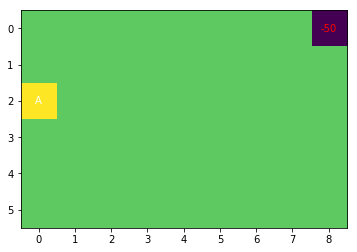

In [27]:
walls = np.array([[0,0,0,0,0,0,0,1,0],
                 [0,0,1,0,0,0,0,1,0],
                 [0,0,1,0,0,0,0,1,0],
                 [0,0,1,0,0,0,0,1,0],
                 [0,0,0,0,0,1,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                ])

walls = np.array([[0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                ])


rewards = np.array(
                [[0,0,0,0,0,0,0,0,-50],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                ])

start_state = np.array([2,0])

transition_noise = .5

gw = grid_world(rewards, walls, start_state, transition_noise)
f,(ax1) = plt.subplots(1) # plot environment
gw.render(ax1)
plt.show()

In [28]:
Tsas = gw.make_Tsas()
Rsa = gw.Rsa

# make a Q agent starting with these
params = {'beta': 5, 'alpha_q': 1, 'gamma': .9}
n_states = int(np.size(walls))


qag = Qagent(params, n_states, Tsas = Tsas, Rsa = Rsa, grid = True)

print('\n\n', qag.Q_hat)

for j in range(4):
    qag.backup_Q(8,j,reset = True)

print('\n\n', qag.Q_hat)

for j in range(4):
    qag.backup_Q(8,j,reset = True)

print('\n\n', qag.Q_hat)

qag.Rsa



 [[0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0

array([[0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [-50.00, -50.00, -50.00, -50.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
  

In [29]:
(s,a) = np.nonzero(gw.Rsa)
s

array([8, 8, 8, 8], dtype=int64)

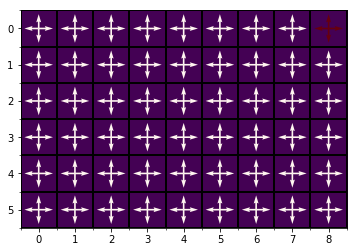

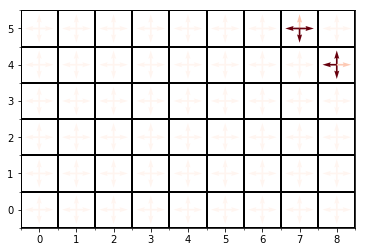

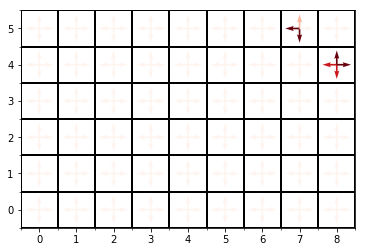

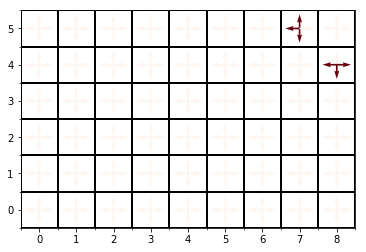

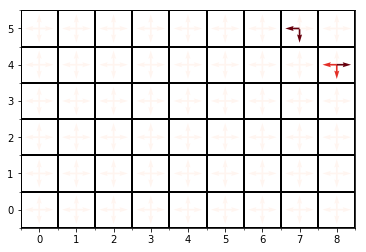

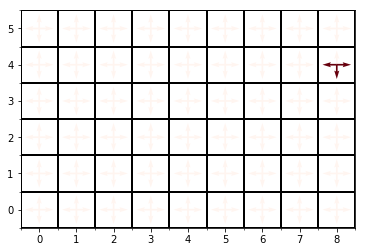

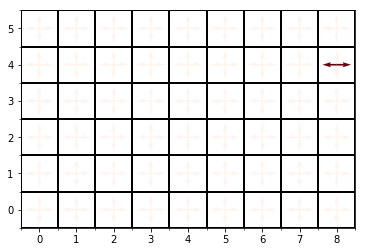

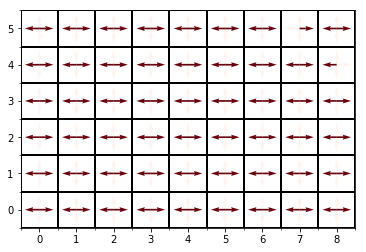

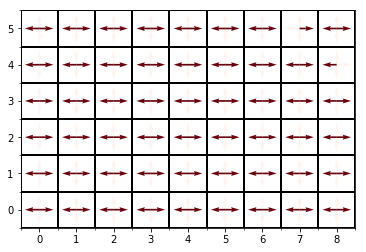

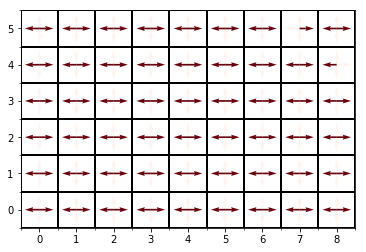

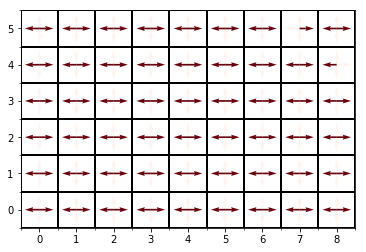

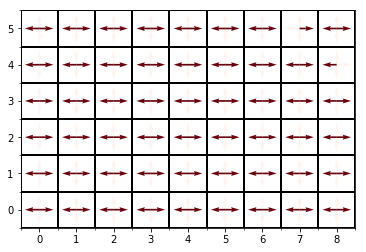

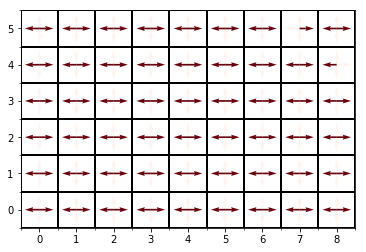

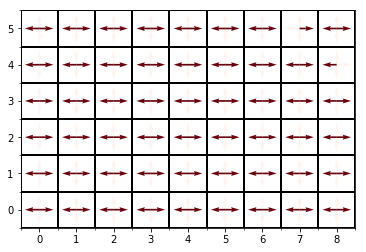

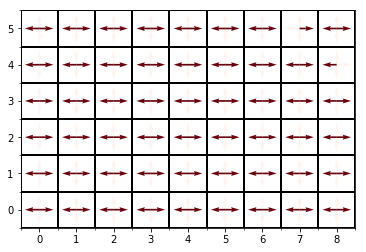

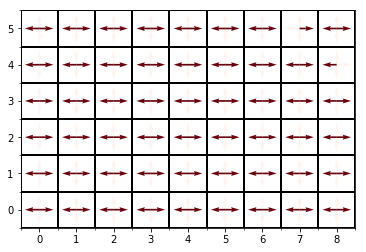

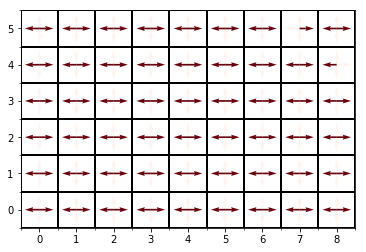

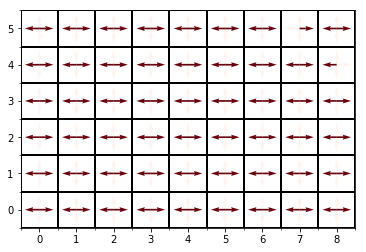

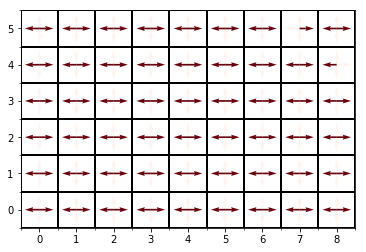

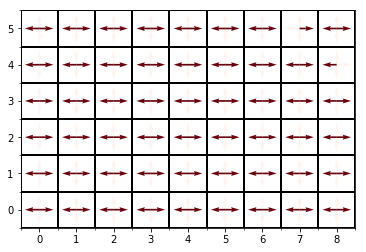

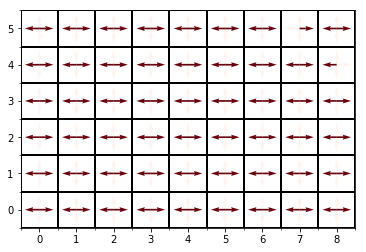

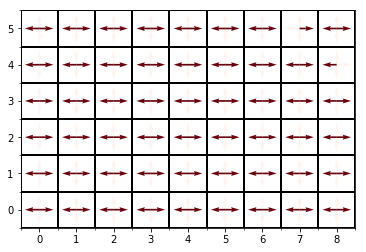

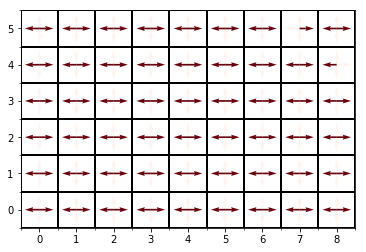

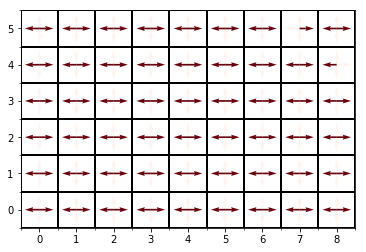

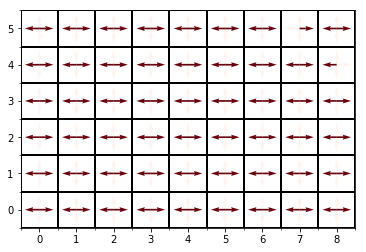

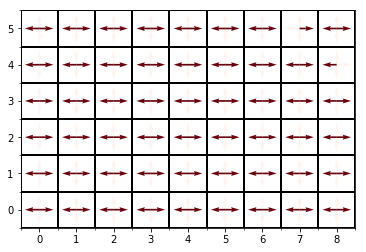

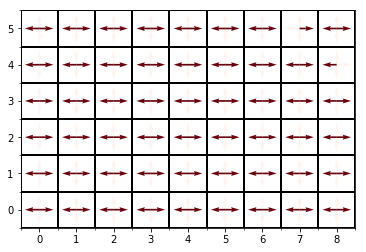

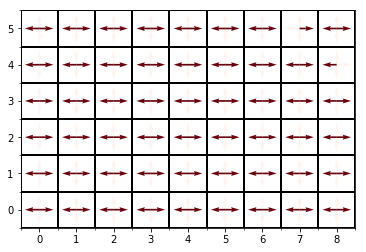

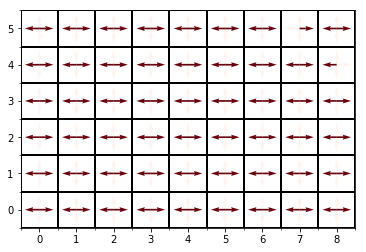

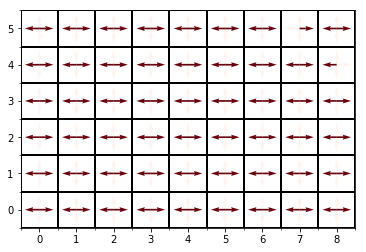

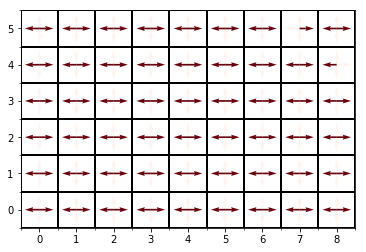

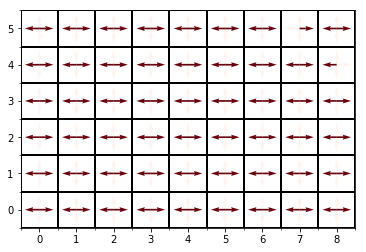

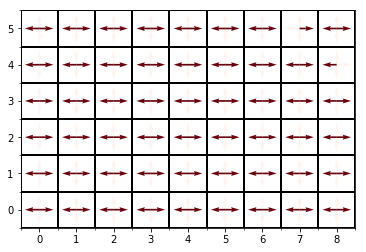

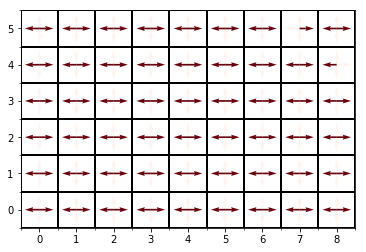

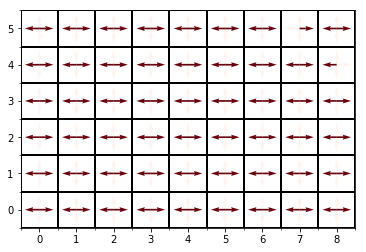

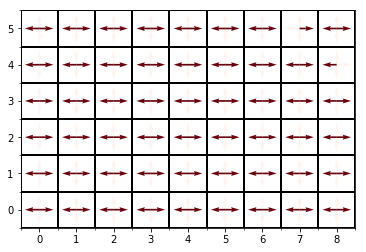

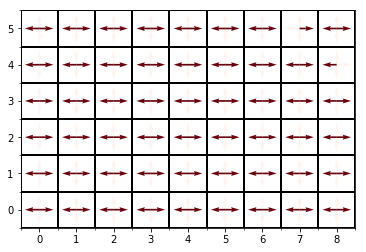

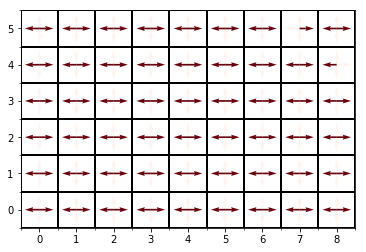

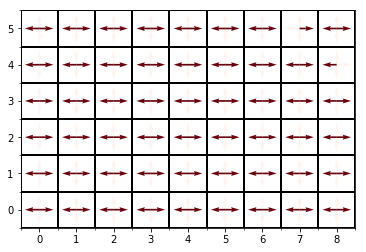

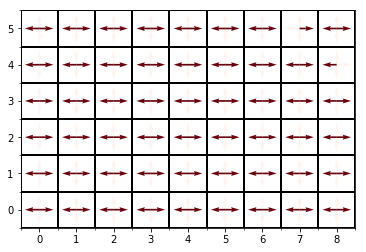

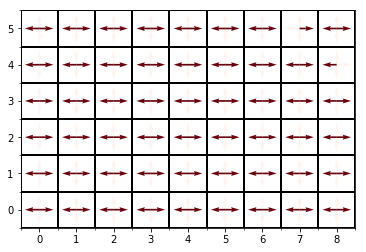

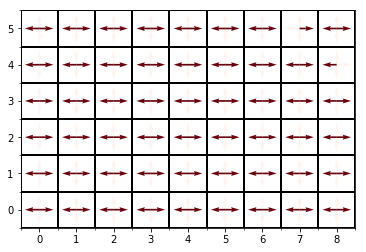

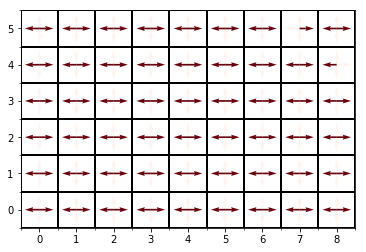

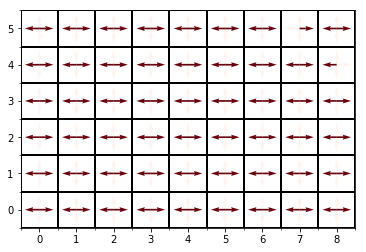

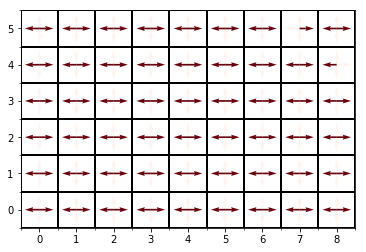

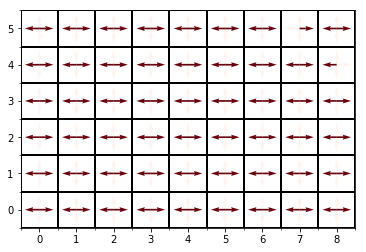

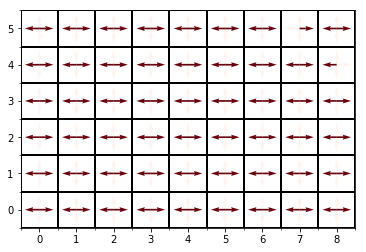

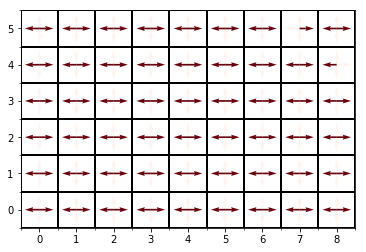

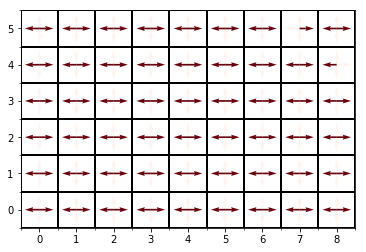

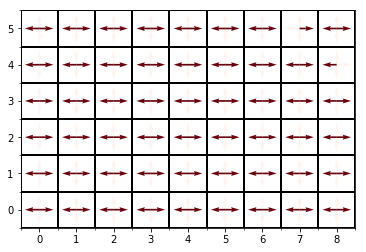

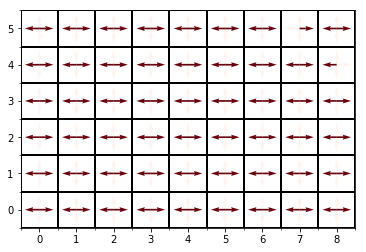

In [38]:
Tsas = gw.make_Tsas()
Rsa = gw.Rsa

# make a Q agent starting with these
params = {'beta': 5, 'alpha_q': 1, 'gamma': .9}
n_states = int(np.size(walls))


qag = Qagent(params, n_states, Tsas = Tsas, Rsa = Rsa, grid = True)

gain = qag.comp_gain()
V = np.max(qag.Q_hat,axis = 1)
f,(ax1) = plt.subplots(1) # plot environment
gw.render_vec(V,ax1)
gw.render_sa_mtx(gain,ax1, over_im = True)

plt.show() # it's in the wrong place

for j in range(4):
    qag.backup_Q(8,j,reset = True)

for i in range(50):
    # get max backup
    (s,a) = np.unravel_index(np.argmax(gain, axis=None), gain.shape)
    # apply backup
    qag.backup_Q(s,a,reset=True)

    # compute gain and state values
    gain = qag.comp_gain()
    #V = np.max(qag.Q_hat,axis = 1)
    f,(ax1) = plt.subplots(1) # plot environment
    #gw.render_vec(V,ax1)
    gw.render_sa_mtx(gain,ax1, over_im = False)

    plt.show() # it's in the wrong place



In [32]:
gain = qag.comp_gain()


In [34]:
qag.Q_hat

array([[0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [-0.08, -0.08, 0.00, -0.40],
       [-1.17, -0.85, -0.71, -3.92],
       [-9.71, -7.26, -6.84, -29.13],
       [-50.00, -50.00, -50.00, -50.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [-0.56, -0.24, 0.00, -0.87],
       [-4.62, -1.61, -1.40, -4.59],
       [-29.12, -6.77, -7.25, -9.66],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [-0.02, 0.00, 0.00, -0.08],
       [-0.86, -0.23, -0.14, -0.51],
       [-3.90, -0.63, -0.91, -1.13],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
 

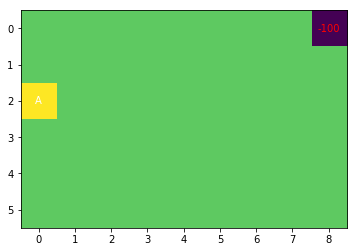

In [7]:
walls = np.array([[0,0,0,0,0,0,0,1,0],
                 [0,0,1,0,0,0,0,1,0],
                 [0,0,1,0,0,0,0,1,0],
                 [0,0,1,0,0,0,0,1,0],
                 [0,0,0,0,0,1,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                ])

walls = np.array([[0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                ])


rewards = np.array(
                [[0,0,0,0,0,0,0,0,-100],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                ])

start_state = np.array([2,0])

transition_noise = 1

gw = grid_world(rewards, walls, start_state, transition_noise)
f,(ax1) = plt.subplots(1) # plot environment
gw.render(ax1)
plt.show()

Tsas = gw.make_Tsas()
Rsa = gw.Rsa

# make a Q agent starting with these
params = {'beta': 10, 'alpha_q': 1, 'gamma': .9}
n_states = int(np.size(walls))


qag = Qagent(params, n_states, Tsas = Tsas, Rsa = Rsa, grid = True)

correct_Q = qag.value_iteration()

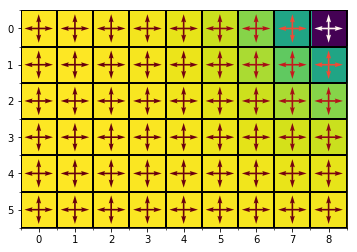

In [8]:
V = np.max(correct_Q, axis= 1)
f,(ax1) = plt.subplots(1) # plot environment
gw.render_vec(V,ax1)
gw.render_sa_mtx(correct_Q,ax1, over_im = True)


In [9]:
correct_Q # something is getting double counted here?

array([[-0.19, -0.19, -0.19, -0.19],
       [-0.43, -0.43, -0.43, -0.43],
       [-0.88, -0.88, -0.88, -0.88],
       [-1.83, -1.83, -1.83, -1.83],
       [-3.84, -3.84, -3.84, -3.84],
       [-8.22, -8.22, -8.22, -8.22],
       [-18.10, -18.10, -18.10, -18.10],
       [-41.42, -41.42, -41.42, -41.42],
       [-100.20, -100.20, -100.20, -100.20],
       [-0.24, -0.24, -0.24, -0.24],
       [-0.41, -0.41, -0.41, -0.41],
       [-0.79, -0.79, -0.79, -0.79],
       [-1.57, -1.57, -1.57, -1.57],
       [-3.17, -3.17, -3.17, -3.17],
       [-6.38, -6.38, -6.38, -6.38],
       [-12.71, -12.71, -12.71, -12.71],
       [-24.36, -24.36, -24.36, -24.36],
       [-41.42, -41.42, -41.42, -41.42],
       [-0.22, -0.22, -0.22, -0.22],
       [-0.35, -0.35, -0.35, -0.35],
       [-0.64, -0.64, -0.64, -0.64],
       [-1.21, -1.21, -1.21, -1.21],
       [-2.29, -2.29, -2.29, -2.29],
       [-4.27, -4.27, -4.27, -4.27],
       [-7.65, -7.65, -7.65, -7.65],
       [-12.72, -12.72, -12.72, -12.72],
      

In [10]:
V

array([-0.19, -0.43, -0.88, -1.83, -3.84, -8.22, -18.10, -41.42, -100.20,
       -0.24, -0.41, -0.79, -1.57, -3.17, -6.38, -12.71, -24.36, -41.42,
       -0.22, -0.35, -0.64, -1.21, -2.29, -4.27, -7.65, -12.72, -18.11,
       -0.19, -0.28, -0.48, -0.86, -1.54, -2.64, -4.31, -6.42, -8.23,
       -0.14, -0.22, -0.36, -0.62, -1.03, -1.64, -2.44, -3.28, -3.83,
       -0.09, -0.18, -0.30, -0.49, -0.78, -1.16, -1.60, -1.90, -1.66])